# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Generate a list of images to read in

In [1]:
import os
import glob

# images are divided up into vehicles and non-vehicles folders, each of which
# contains subfolders. First locate vehicle images

basedir = '/Users/dyz/Downloads/vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of vehicle images found:', len(cars))
with open('cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn + '\n')

# non vehicle images
basedir = '/Users/dyz/Downloads/non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of non vehicle images found:', len(notcars))
with open('notcars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn + '\n')

Number of vehicle images found: 8792
Number of non vehicle images found: 8968


## Define functions required for feature extraction etc

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline


In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    features = []
    for file in imgs:
        file_features = []
        img = mpimg.imread(file)
        #2) Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            file_features.append(spatial_features)
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            file_features.append(hist_features)
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))

    #9) Return concatenated array of features for all the files
    return features


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
    

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.decision_function(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction > 0.5:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i + 1)
        plt.title(i + 1)
        if len(img.shape) < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)
        plt.title(titles[i])
        
def plot3d(pixels, colors_rgb,
    axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation



## HOG feature parameters

In [5]:
carimage = mpimg.imread(cars[0])
notcarimage = mpimg.imread(notcars[0])
print(carimage.shape)
print(notcarimage.shape)

def bin_spatial0(img, size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def bin_spatial1(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    # Use cv2.resize().ravel() to create the feature vector
    # Return the feature vector
    return np.hstack((color1, color2, color3))

print(bin_spatial0(carimage)[:9])
print(bin_spatial1(carimage)[:9])

(64, 64, 3)
(64, 64, 3)
[ 0.61176473  0.65882355  0.63921571  0.60980392  0.65294123  0.63529414
  0.60196078  0.63921571  0.62352943]
[ 0.61176473  0.60980392  0.60196078  0.5862745   0.55882359  0.52941179
  0.52156866  0.50196081  0.47647059]


In [6]:
def HOG_param_exploration(img1, img2, orients = 6, pix_per_cell = 8, cells_per_block = 2):
    f1, h1 = get_hog_features(img1,orients,pix_per_cell,cells_per_block,True,False)
    print('HOG dimension: ', f1.shape)
    f1, h1 = get_hog_features(img1,orients,pix_per_cell,cells_per_block,True,True)
    print('HOG features:', f1.shape)
    f2, h2 = get_hog_features(img2,orients,pix_per_cell,cells_per_block,True,True)
    print('distance of car and non car HOG feature vectors:', np.linalg.norm(f2-f1))
    fig = plt.figure()
    visualize(fig, 1, 2, [h1,h2], ['', ''])

HOG dimension:  (7, 7, 2, 2, 6)
HOG features: (1176,)
distance of car and non car HOG feature vectors: 2.38234371541
HOG dimension:  (8, 8, 1, 1, 6)
HOG features: (384,)
distance of car and non car HOG feature vectors: 3.76111336373
HOG dimension:  (7, 7, 2, 2, 9)
HOG features: (1764,)
distance of car and non car HOG feature vectors: 2.40785095273
HOG dimension:  (8, 8, 1, 1, 9)
HOG features: (576,)
distance of car and non car HOG feature vectors: 3.6547053891
HOG dimension:  (3, 3, 2, 2, 6)
HOG features: (216,)
distance of car and non car HOG feature vectors: 0.79194006214
HOG dimension:  (4, 4, 1, 1, 6)
HOG features: (96,)
distance of car and non car HOG feature vectors: 1.41870932594
HOG dimension:  (3, 3, 2, 2, 9)
HOG features: (324,)
distance of car and non car HOG feature vectors: 0.794630196639
HOG dimension:  (4, 4, 1, 1, 9)
HOG features: (144,)
distance of car and non car HOG feature vectors: 1.48928671611


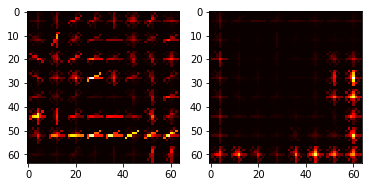

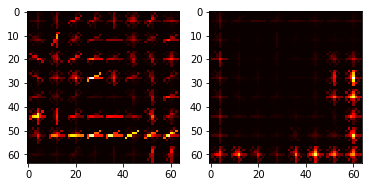

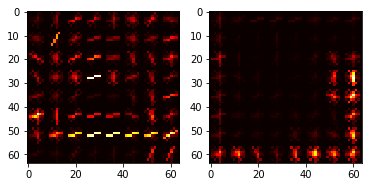

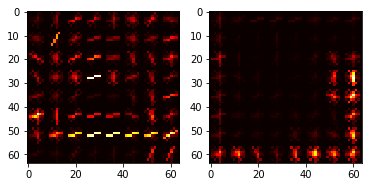

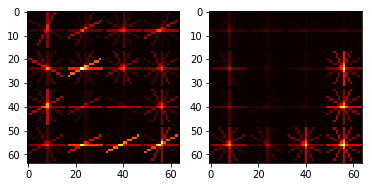

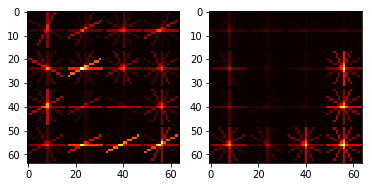

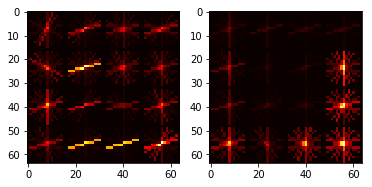

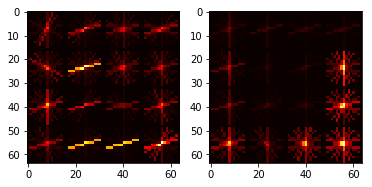

In [7]:
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],6,8,2)
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],6,8,1)
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],9,8,2)
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],9,8,1)
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],6,16,2)
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],6,16,1)
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],9,16,2)
HOG_param_exploration(carimage[:,:,0],notcarimage[:,:,0],9,16,1)

## Visualize the feature for car and non car image

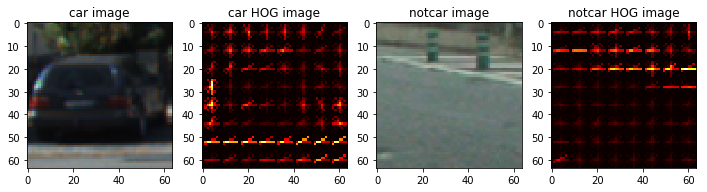

In [8]:
# choose random car / non car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# read in car / non car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

#define feature parameters

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space = color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis = True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space = color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis = True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12, 3))
visualize(fig, 1, 4, images, titles)

## Train the model, tweak feature selection to optimize validation accuracy

In [9]:
#define feature parameters

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space = color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, color_space = color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, 'seconds to complete feature extraction')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


97.42203402519226 seconds to complete feature extraction
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
7.26 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  0.  1.  1.]
0.00193 Seconds to predict 10 labels with SVC


NameError: name 'xscaler' is not defined

In [11]:
import pickle
pickle.dump(svc, open('svc.pkl', 'wb'))
pickle.dump(X_scaler, open('xscaler.pkl', 'wb'))

## Test the classifier on test images, tweak parameters to optimize car detection

1.795233964920044 seconds to process one image searching 430 windows
1.713076114654541 seconds to process one image searching 430 windows
1.715005874633789 seconds to process one image searching 430 windows
1.7155969142913818 seconds to process one image searching 430 windows
1.6928050518035889 seconds to process one image searching 430 windows
1.7346720695495605 seconds to process one image searching 430 windows


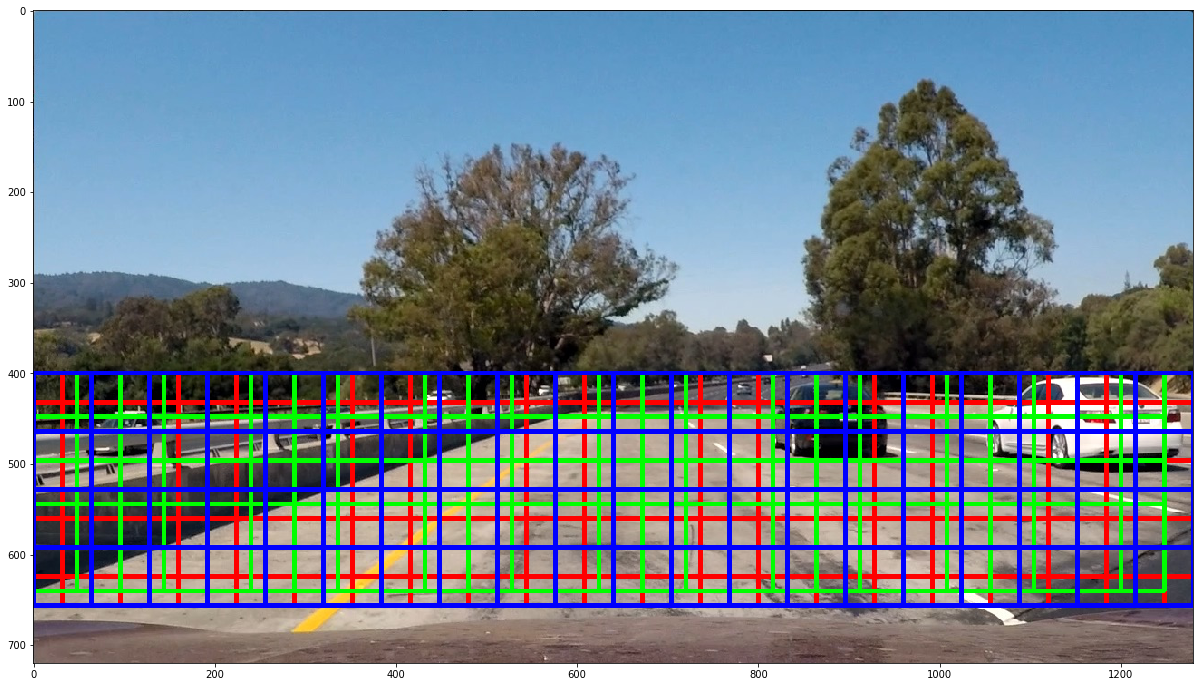

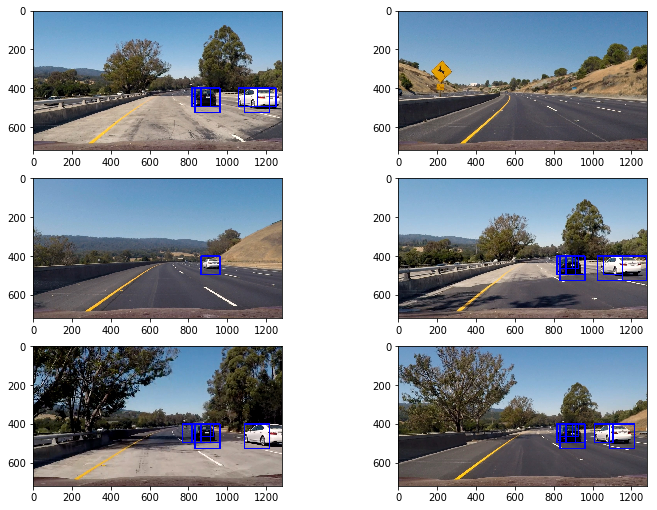

In [12]:
import pickle
searchpath = 'test_images/*'
svc = pickle.load(open('svc.pkl', 'rb'))
X_scaler = pickle.load(open('xscaler.pkl', 'rb'))
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
overlap = 0.5
run_once = True
windows = []
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # needs to normalize to png with which the classifier is trained
    img = img.astype(np.float32)/255
    
    if run_once:
        windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
        
        all_windows_img = draw_boxes(draw_img, windows, color=(255, 0, 0), thick=3)                       

        windows_more = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))
        windows.extend(windows_more)
        
        all_windows_img = draw_boxes(all_windows_img, windows_more, color=(0, 255, 0), thick=3)                       


        windows_more = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
        windows.extend(windows_more)
        
        all_windows_img = draw_boxes(all_windows_img, windows_more, color=(0, 0, 255), thick=3)                       

        run_once = False

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    hot_window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)                    
    images.append(hot_window_img)
    titles.append('')
    print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')

plt.figure(figsize=(24,12))
plt.imshow(all_windows_img)
fig = plt.figure(figsize=(12,18))
visualize(fig, 6, 2, images, titles)


## Optimize the computation by scaling + HOG entire image once + subsampling

In [13]:
hog_desc = None

def init_hog(img_shape, orient=9, pix_per_cell=8, cell_per_block=2, reset=False):
    global hog_desc
    if hog_desc is None or reset:
        cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
        block_size = (cell_per_block, cell_per_block)  # h x w in cells
        nbins = orient  # number of orientation bins

        # winSize is the size of the image cropped to an multiple of the cell size
        hog_desc = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                          img_shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

    return hog_desc

0.2907850742340088 seconds to HOG
0.6084940433502197 seconds to process 912 windows
0.2835359573364258 seconds to HOG
0.5794088840484619 seconds to process 912 windows
0.27052903175354004 seconds to HOG
0.5514280796051025 seconds to process 912 windows
0.26415491104125977 seconds to HOG
0.5535900592803955 seconds to process 912 windows
0.27244019508361816 seconds to HOG
0.546457052230835 seconds to process 912 windows
0.2681691646575928 seconds to HOG
0.5454368591308594 seconds to process 912 windows


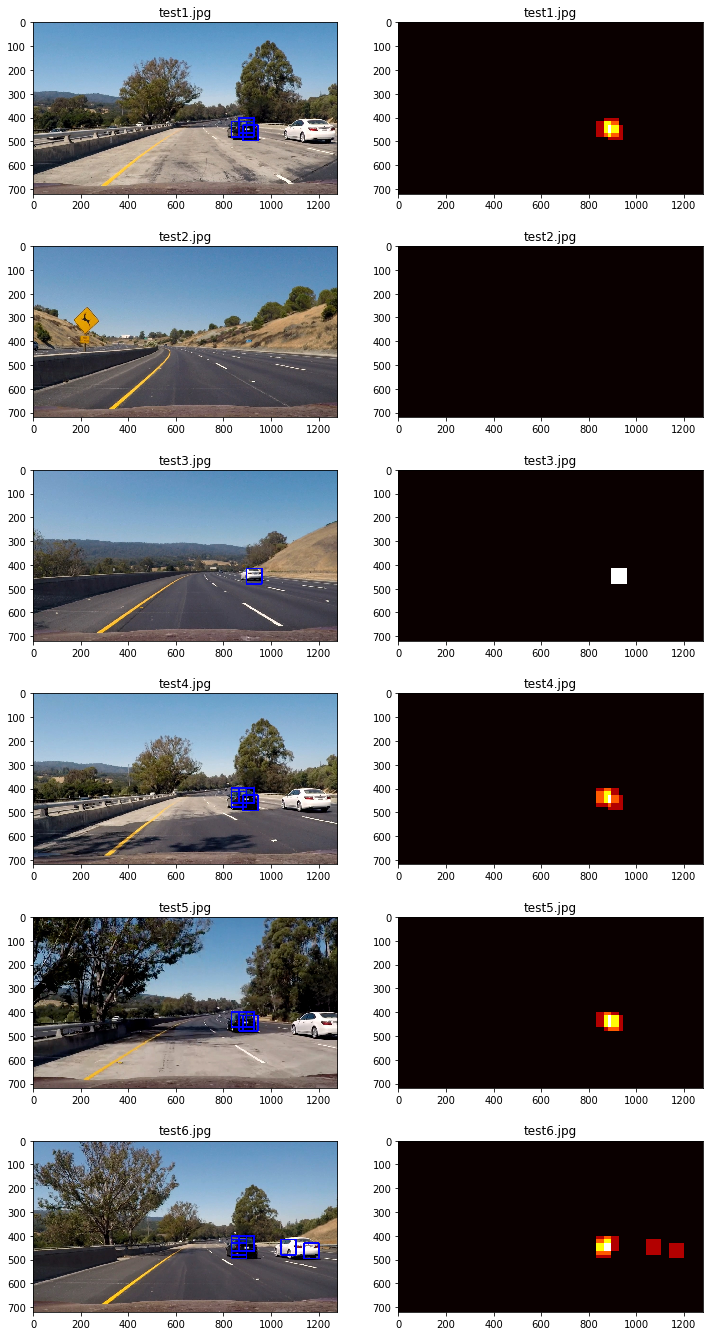

In [14]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []

ystart = 400
ystop = 656
scale = 1.0
hogd = None

for img_src in example_images:
    img_boxes = []
    t = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # init the heat map
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell) - 1 # cells per block: 2
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    # instead of overlap, define how many cells to step
    # this is a smaller step size since overlap equals to 1 - 2 / 8 = 0.75
    # since there are lots of time saved by not computing HOG for each window
    # search more carefully with larger overlap
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
#     hog1 = hogd.compute(ch1)[:,0]
#     hog2 = hogd.compute(ch2)[:,0]
#     hog3 = hogd.compute(ch3)[:,0]
    
    print(time.time() - t, 'seconds to HOG')
    t = time.time()



    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # extract HOG for this patch
#             ctrans_tosearch_hog = ctrans_tosearch[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window]
#             cvbuc3image = (ctrans_tosearch_hog*255).astype(np.uint8)
#             if hogd is None:
#                 hogd = init_hog(ctrans_tosearch_hog.shape, orient, pix_per_cell, cell_per_block, True)
#             hog_features = hogd.compute(cvbuc3image)[:,0]



            hog_feat1 = hog1[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop : ytop + window, xleft : xleft + window], (window,window))

            # color feastures
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # scale features and predict
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.decision_function(test_features)
            
            if test_prediction > 0.5:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart),
                              (0,0,255), 6)
                img_boxes.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart : ytop_draw + ystart + win_draw, xbox_left : xbox_left + win_draw] += 1
    
    print(time.time() - t, 'seconds to process', nxsteps * nysteps, 'windows')
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_images.append(heatmap)
    out_titles.append(img_src[-9:])
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, out_images, out_titles)


## Video pipeline

In [51]:
def find_cars(img, scale = 1.0, ystart = 400, ystop = 656, xstart = 640, xstop = 1216):
    t = time.time()
    draw_img = np.copy(img)
    # init the heat map
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 # cells per block: 2
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    # instead of overlap, define how many cells to step
    # this is a smaller step size since overlap equals to 1 - 2 / 8 = 0.75
    # since there are lots of time saved by not computing HOG for each window
    # search more carefully with larger overlap
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # extract HOG for this patch
            hog_feat1 = hog1[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos : ypos + nblocks_per_window, xpos : xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop : ytop + window, xleft : xleft + window], (window,window))

            # color feastures
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # scale features and predict
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.decision_function(test_features)
            
            if test_prediction > 0.3:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left+xstart, ytop_draw + ystart), (xbox_left +xstart + win_draw, ytop_draw + win_draw + ystart),
                              (0,0,255), 6)
                img_boxes.append(((xbox_left+xstart, ytop_draw + ystart), (xbox_left+xstart + win_draw, ytop_draw + win_draw + ystart)))
                heatmap[ytop_draw + ystart : ytop_draw + ystart + win_draw, xbox_left +xstart: xbox_left +xstart+ win_draw] += 1
#     print(time.time() - t, 'seconds to process', nxsteps * nysteps, 'windows') 
    return draw_img, heatmap


In [52]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        xmin = np.min(nonzerox)
        xmax = np.max(nonzerox)
        ymin = np.min(nonzeroy)
        ymax = np.max(nonzeroy)
#         if xmin < 400:
#             continue
        # Define a bounding box based on min/max x and y
        bbox = ((xmin, ymin), (xmax, ymax))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


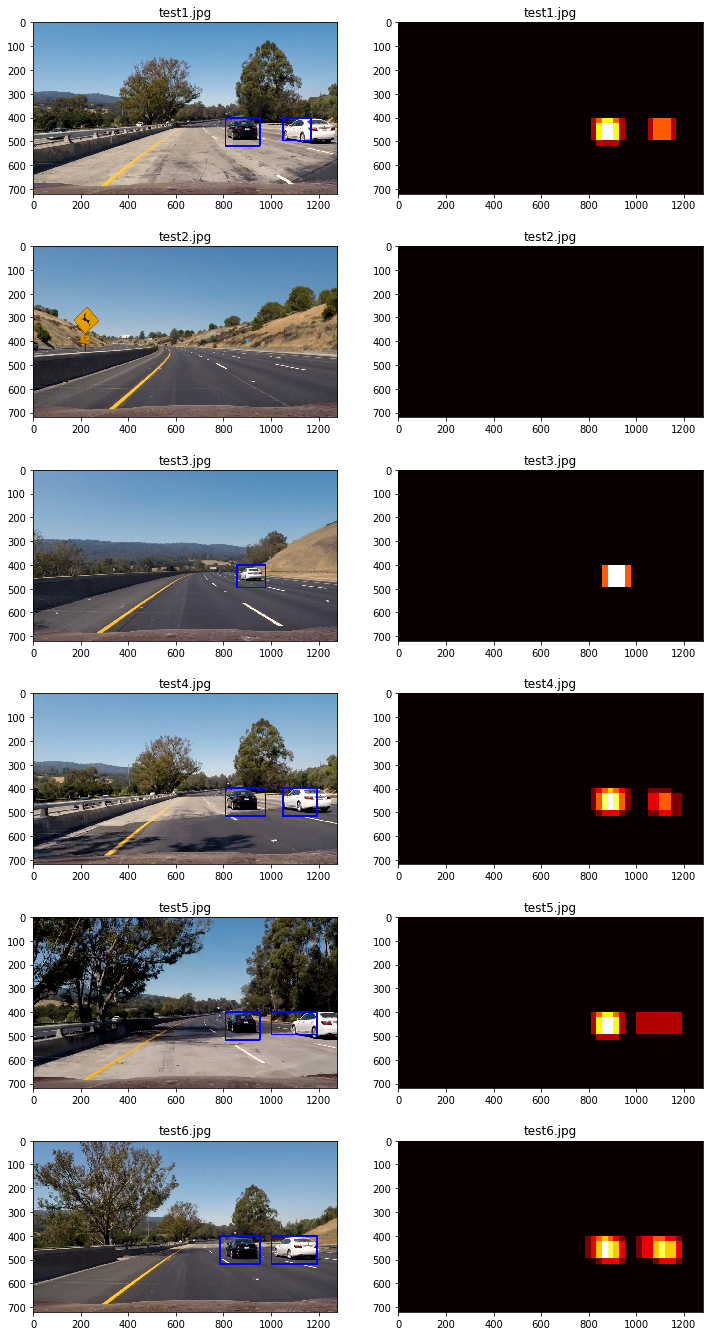

In [53]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 6, 2, out_images, out_titles)

In [68]:
def process_image_multiimage(img):
    global frame_count
    global heat_map_list
    global heat_map_acc
    scales = [1, 1.2, 1.4]
    range_start = [640, 841, 1041]
    range_end = [1040, 1240, 1279]
    lookback_frames = 9 * len(scales)    
    
    for i,s in enumerate(scales):
        out_img, heat_map = find_cars(img, s, 400,656,range_start[i], range_end[i])
        heat_map_list.append(heat_map)
        heat_map_acc += heat_map
        
    if frame_count > lookback_frames:
        for s in scales:
            heat_map_pop = heat_map_list.pop(0)
            heat_map_acc -= heat_map_pop
        heat_map_th = apply_threshold(heat_map_acc, 1)
    else:
        heat_map_th = heat_map_acc
    labels = label(heat_map_th)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    frame_count += 1
    return draw_img

In [69]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
out_dir='./'
output = out_dir+'processed_test_video.mp4'
heat_map_list = []
heat_map_acc = np.zeros((720, 1280))
frame_count = 0
clip = VideoFileClip("test_video.mp4")
out_clip = clip.fl_image(process_image_multiimage) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_test_video.mp4
[MoviePy] Writing video ./processed_test_video.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  1.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_test_video.mp4 

CPU times: user 16.9 s, sys: 907 ms, total: 17.8 s
Wall time: 19.3 s


In [72]:
output = out_dir+'processed_project_video.mp4'
heat_map_list = []
heat_map_acc = np.zeros((720, 1280))
frame_count = 0
frame_has_car = False
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_image_multiimage) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [09:47<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

CPU times: user 9min 16s, sys: 29.1 s, total: 9min 45s
Wall time: 9min 49s
